In [1]:
!pip install torch torchvision matplotlib -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:04<00:00, 36.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + Pool
        x = torch.flatten(x, 1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = self.dropout(self.relu(self.fc2(x)))  # FC2 + ReLU + Dropout
        x = self.fc3(x)  # Output layer
        return x


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print("Finished Training")


Epoch [1/10], Loss: 1.6190
Epoch [2/10], Loss: 1.1991
Epoch [3/10], Loss: 1.0340
Epoch [4/10], Loss: 0.9196
Epoch [5/10], Loss: 0.8457
Epoch [6/10], Loss: 0.7871
Epoch [7/10], Loss: 0.7412
Epoch [8/10], Loss: 0.6935
Epoch [9/10], Loss: 0.6608
Epoch [10/10], Loss: 0.6224
Finished Training


In [ ]:
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert images to numpy for display
images = images.cpu().numpy()
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = np.transpose(images[i], (1, 2, 0))  # Convert to HWC format
    img = img * 0.5 + 0.5  # Unnormalize
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]} (GT: {classes[labels[i]]})")
    ax.axis("off")

plt.show()


In [8]:
torch.save(model.state_dict(), "cifar10_cnn.pth")

<ipython-input-10-ac4290623551>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cifar10_cnn.pth", map_location=device))


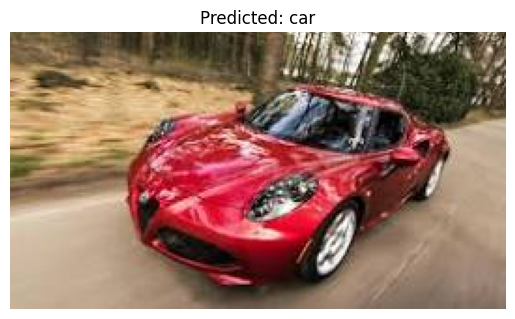

Predicted Class: car


In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
model.load_state_dict(torch.load("cifar10_cnn.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize same as training
])

# Function to predict an image
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open image
    image = transform(image).unsqueeze(0).to(device)  # Apply transforms and add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # Show image and prediction
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {classes[predicted.item()]}")
    plt.axis("off")
    plt.show()

    return classes[predicted.item()]

image_path = "car.jpg"  # Replace with the actual image path
predicted_class = predict_image(image_path)
print("Predicted Class:", predicted_class)


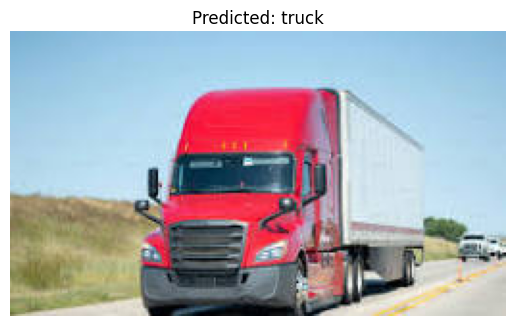

Predicted Class: truck


In [11]:
image_path = "truck.jpg"  # Replace with the actual image path
predicted_class = predict_image(image_path)
print("Predicted Class:", predicted_class)

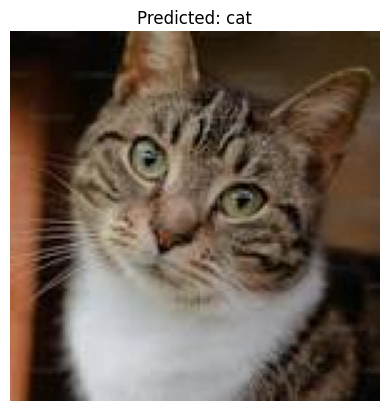

Predicted Class: cat


In [12]:
image_path = "cat.jpg"  # Replace with the actual image path
predicted_class = predict_image(image_path)
print("Predicted Class:", predicted_class)